In [7]:
import numpy as np
import lusee
import refspec
import os
import fitsio
from scipy.interpolate import interp1d

In [3]:
filename = os.environ['LUSEE_DRIVE_DIR']+'/Simulations/PDR/hfss_lbl_3m_75deg_R10.fits'
da = lusee.Data(filename)

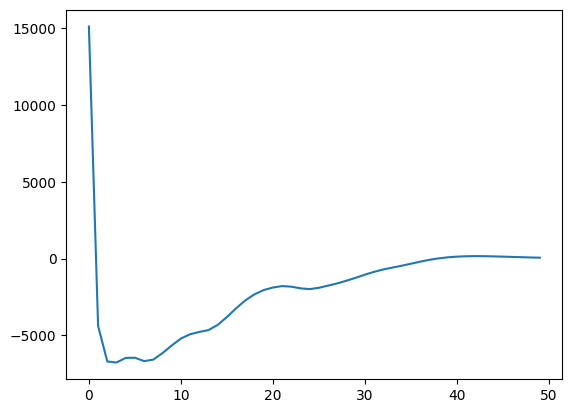

In [4]:
ndx=25000
#plt.plot(da[ndx,'11R',:])
#plt.plot(da[ndx,'33R',:])
plt.plot(da[ndx,'13I',:])



In [18]:
T=lusee.Throughput()
freq = da.freq
P11 = da[ndx,'11R',:]*T.T2Vsq(freq)
P33 = da[ndx,'33R',:]*T.T2Vsq(freq)
P13 = da[ndx,'13R',:]*T.T2Vsq(freq)+ 1j*da[ndx,'13I',:]*T.T2Vsq(freq)
# need to interpolate, extrapolate
f=np.linspace(0,52,1000)
P11 = interp1d(freq,P11,fill_value=P11[0],bounds_error=False)(f)
P33 = interp1d(freq,P33,fill_value=P33[0],bounds_error=False)(f)
P13 = interp1d(freq,P13,fill_value=0,bounds_error=False)(f)



In [19]:
Pmat = np.array([[P11,P13],[np.conj(P13),P33]]).T
Pmat.shape

(1000, 2, 2)

In [67]:
Nsec = 2
cfg = refspec.cppyy.gbl.SpecConfig()
sampling_rate = cfg.sampling_rate
block_size = cfg.Nfft ## irrelevant here
Nsamples = int(Nsec*sampling_rate)
Nchannels = cfg.Nchannels  = 2
Nblocks = Nsamples//block_size+1
seed =1 
tofile = True


source = refspec.CorrelatedSpecSource (f,Pmat, sampling_rate, block_size, Nchannels, Nblocks+1, False, False, seed, True)
if tofile:
    bits = 14
    bit_level = 1/2**(bits-1)/1000
    filenames = ['jfet_waveform_230614_ch1.bin','jfet_waveform_230614_ch2.bin']
    sink = refspec.FileStreamSink (source, filenames, bit_level = bit_level, bits=bits);
    sink.write_data(Nsamples)
    np.savetxt('jfet_waveform_230614_pk.txt',np.vstack((f,P11,P33,np.real(P13),np.imag(P13))).T)
else:
    output = refspec.SpecOutput(cfg)
    spectrometer = refspec.RefSpectrometer(source, cfg)
    spectrometer.run(output)
    fundamental = cfg.fundamental_frequency()
    fo = fundamental*np.arange(cfg.Nbins())/1e6
    Pko = np.array([[output.get_avg_pspec(j, i) for i in range(0, cfg.Nbins())] for j in range(4)])

 I am here... 1000 2
 I am here... 1000 2
*** Planning 204808192 samples = 2.00008 seconds. ***
*** Generating... ***
*** Seed: 1 ***
*** Transforming... ***
  Channel 0...
  Channel 1...
*** Done ***


In [68]:
data1=np.fromfile('jfet_waveform_230614_ch1.bin',dtype=np.int16)
data2=np.fromfile('jfet_waveform_230614_ch2.bin',dtype=np.int16)

In [71]:
bits = 14
1/2**(bits-1)/1000,1.5e-8

1.220703125e-07

[]

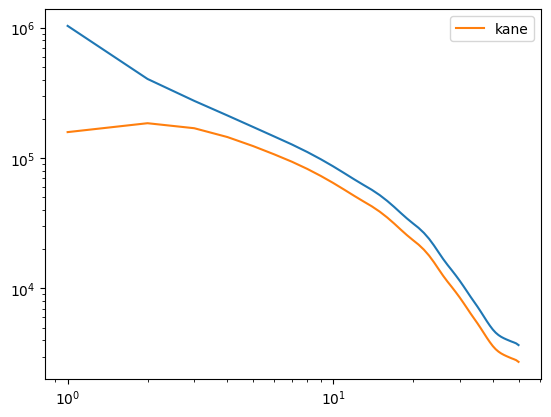

In [66]:
plt.plot(freq,da[:,'11R',:].mean(axis=0))
from scipy.ndimage import gaussian_filter
beam = lusee.Beam()
sky_frac_in = 1-beam.ground_fraction()
sky_frac_s = gaussian_filter(sky_frac_in,1)
sky_frac = interp1d(np.hstack((0,freq)),np.hstack((0,sky_frac_s)),kind='quadratic', bounds_error=False, fill_value='extrapolate')
plt.plot(freq, lusee.monosky.T_C(freq).value*sky_frac(freq),label='kane')
plt.legend()
plt.loglog()

In [70]:
pwd

'/home/anze/Dropbox/work/lusee/luseepy'